In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')
alls = pd.read_csv('allsummtab.csv') #most updated table

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

srcns = np.array(alls['src_n'])
#saving figure function
def sf(name,dpi=150):
    plt.savefig(f'Figs/{name}.png',bbox_inches='tight',dpi=dpi)
#simple plotting function
def plot(s,calib=False,both=True):
    try:band = o.getIV(s,cross,both=both,stack=True,plot=True,mlist=mlist1,figsize=(4,3),calib=calib)
    except:band = o.getIV(s,cross2,both=both,stack=True,plot=True,mlist=mlist2,figsize=(4,3),calib=calib)

# Notebook Notes
- send to Georgios to get checked --> make edits, add analysis, and run through analysis Wednesday
- so far, as Georgios mentioned, cycle error seems to be the most important
- improve sampling

# Example TOA Calculation 
- but will find the common sampling times using multiple light curves
- other simple to-do: automatically use more years based on period

In [2]:
iband = o.getIV(96,cross2,stack=True,both=False,mlist=mlist2)

In [80]:
def year(ib,p,n=1,start='current',mult=1,pbins=16,det=True,plotphase=False,minpoints=100,retref=False):
    '''
    Find TOA of maximum for the nth year of iband data
    --> now also requires that there are minpoints in that year (same start date, but extends if need be)
    ib: I band table, with or without detrended I mag
    p: initial period guess in days
    n: year of data (starting at 1)
    start: choose a reference time
           'first' means the beginning of iband; 'current' gives beginning of year
    mult: multiples of year to include (e.g., 1 gives 1*365 days)
    pbins: number of phase bins
    det: whether or not to use spline-detrended data in phase-folding
    plotphase: for debugging mostly, plot the phase-folded data
    retref: return TOAs, reference time (necessary since not yearly 
            spacing once min points requirement)
    '''
    #if column of detrended not already there, detrend
    if 'I detrend' not in ib.columns: o.splinedetrend(ib)
    #add column of initial indices
    ib['ind'] = np.arange(len(ib))
    #first time in overall table
    t0 = ib['MJD-50000'][0]
    #make filtered table with just nth year
    if n>1: 
        y = ib[ib['MJD-50000']>t0+(n-1)*365]
        if len(y)==0: return 'not enough left'
        #get first index
        init_ind = y['ind'][0]
    else: y = ib
    #upper bound
    y = y[y['MJD-50000']<t0+n*365]

    #check that there are sufficient points
    if len(y)<minpoints:
        y = ib[init_ind:init_ind+minpoints]
    #new 0 time
    nt0 = y['MJD-50000'][0]

    #find reference time
    if start == 'first': ref = t0 #reference time beginning of whole table
    elif start == 'current': ref = nt0 #reference time beginning of current year
    else: return 'please pass in "first" or "current" for start'
    
    #subtract reference time from all times in year table
    y['MJD-50000'] -= ref
    
    #phase-fold year of data
    mid,avg,err = o.meanphase(y,p,pbins=pbins,det=det,double=True,sterr=True,stdev=True,divide=True)
    #for debugging: plot phase
    if plotphase:
        plt.figure(figsize=(4,3))
        plt.step(mid,avg,where='mid',color='black')
        #add errors as one sigma
        plt.errorbar(mid,avg,yerr=err,color='black',marker='',linestyle='none',alpha=0.4)
        #flip y axis 
        maxa,mina = np.nanmax(avg),np.nanmin(avg)
        maxa += np.nanmax(err)
        mina -= np.nanmax(err)
        plt.ylim(maxa+.01,mina-.01)
    
    #find peak (min since in magnitudes)
    #peakind = np.where(avg == np.nanmin(avg))[0][0] 
    peakp = mid[avg==np.nanmin(avg)][0] #phase loc of folded max
    maxday = p*peakp #peak in days (phase*period)
    #return time of arrival and reference time used
    if retref: return nt0+maxday,ref
    #return just toa
    return nt0+maxday

#loop through as many years as possible above
def yearloop(src,p,start='first',mult=1,pbins=16,det=True,plot=True,findpd='no',cyc=False,lin=False,plotphase=False,minpoints=100):
    '''
    loop through all years of LC src
    arguments the same, but source number rather than iband given
    plot: plots TOA vs. year number
    lin: call linfit function instead of plotting
    
    TO DO: option to add manual start time for year cuts
    '''
    #get iband LC
    try: iband = o.getIV(src,cross,stack=True,both=False,mlist=mlist1)
    except: iband = o.getIV(src,cross2,stack=True,both=False,mlist=mlist2)
    #if findpd not no, overwrite p with est. period or best auto det pd
    if findpd == 'est': p = float(alls[alls['src_n']==src]['est. period'])
    if findpd == 'best' or p == 0:p = float(alls[alls['src_n']==src]['best auto det pd'])
    
    #find number of years of data
    time = iband['MJD-50000']
    nyr = int((time[-1]-time[0])/365)
    print(nyr)
    #list of TOAs 
    toas = []
    ref_times = []
    for i in range(1,nyr+1):
        rets = year(iband,p=p,n=i,start=start,mult=mult,pbins=pbins,det=det,plotphase=plotphase,minpoints=minpoints,retref=True)
        if rets == 'not enough left': break
        else: toas.append(rets[0]); ref_times.append(rets[1])
    if lin: #plot TOAs vs. year number with linear fit as well as residuals vs. year from linear fit
        linfit([toas,ref_times])
        return toas,p
    if plot:
        plt.figure(figsize=(5,4))
        plt.scatter(ref_times,toas,color='black',label=f'{p:.2f}')
        plt.legend()
#         plt.xticks(np.arange(1,nyr+1,2))
        #add error bars based on half width of phase bins
        wid = p/(2*pbins)
        plt.errorbar(ref_times,toas,yerr=wid,ls='none',color='black')
        plt.xlabel('reference time',fontsize=14)
        label = 'time of first max in year'
        plt.ylabel(label,fontsize=14)
    return toas   

In [102]:
def cycle(toas,p,dec=True):
    '''Plot the number of cycles elapsed each year
    dec: only plot decimals after number of cycles'''
    tarr = np.array(toas)
    #array of cycles between TOAs: (TOA - previous TOA)/period guess
    cyc = (tarr[1:]-tarr[:-1])/p
    #option to take off integer part of each cycle value, just leaving "error"
    if dec:
        for c in range(len(cyc)):
            cyc[c] -= int(cyc[c])
    #plot 
    plt.figure(figsize=(5,4))
    plt.scatter(np.arange(1,len(cyc)+1),cyc,color='maroon')
    plt.ylabel('# cycles between TOAs',fontsize=14)
    plt.xlabel('~year number',fontsize=14)
    
    
def linfit(yr_return,clean=True,clean_cut=200):
    '''Fit line to TOAs and plot residuals
    clean: get rid of outliers (initial residuals above clean_cut) and re-fit
    TO DO: use break point to make separate fits; higher order'''
    toas = yr_return[0]
    refs = yr_return[1]
    #xax = np.arange(1,len(toas)+1)
    fit = np.polyfit(refs,toas,1)
    line = np.array(refs)*fit[0]+fit[1]
    subline = toas - line
    if clean: #another iteration after removing outliers
        good = np.where(np.abs(np.array(subline))<clean_cut)
        t = np.array(toas)
        r = np.array(refs)
        new_toa = t[good[0]]
        new_refs = r[good[0]]
        #for debugging
#         print(len(toas)-len(new_toa))
    #fit line again
#     xax = np.arange(1,len(new_toa)+1)
    fit = np.polyfit(new_refs,new_toa,1)
    line = new_refs*fit[0]+fit[1]
    subline = new_toa - line
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    ax[1].scatter(new_refs,subline,color='navy')
    ax[1].set_ylabel('residuals from linear fit (days)',fontsize=14)
    ax[1].set_xlabel('year number',fontsize=14)
    #plot original with fit
    ax[0].scatter(new_refs,new_toa,color='black')
    #plot best fit line
    ax[0].plot(new_refs,line,color='grey')
    ax[0].set_xlabel('reference time',fontsize=14)
    ax[0].set_ylabel('TOA',fontsize=14)
    return

#### added points threshold but then have to account for there being fewer chunks than expected based on total number of years
- but with this update, 'first' may not be working

In [36]:
alls[alls['src_n']==28]['est. period']

25    88.3
Name: est. period, dtype: float64

# example with one of the best-looking periods

18


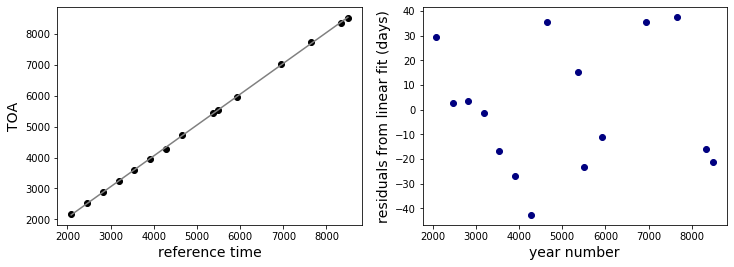

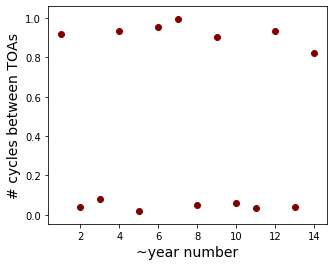

In [108]:
toas = yearloop(28,0,start='current',mult=1,pbins=16,det=True,plot=True,findpd='best',cyc=False,lin=True,plotphase=False,minpoints=80)
#cycle plot
cycle(toas[0],88.343536)

if perfect period, start time should be well-correlated with time of peak
- below: example from Overleaf with great shapes until last bit
- can see error dips into 'bad' region towards the end

18


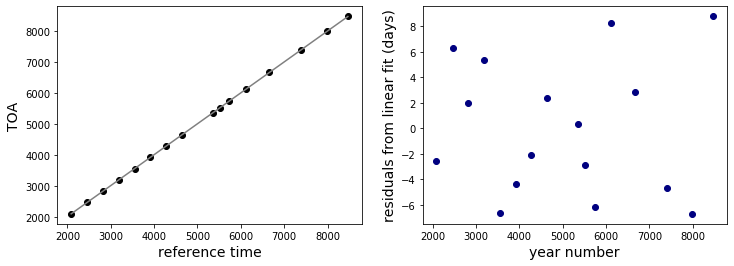

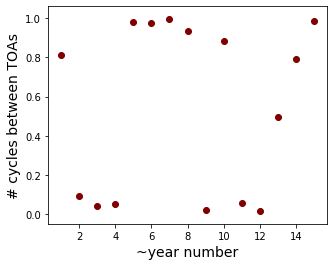

In [109]:
#also good but period disappearance at the end
toas1 = yearloop(96,0,start='current',mult=1,pbins=16,det=True,plot=True,findpd='best',cyc=False,lin=True,plotphase=False)
cycle(toas1[0],17.55)

# A Few More Examples
- current way the minimum points works: the next year in loop starts at the same place so when there aren't enough points, some are re-used

18


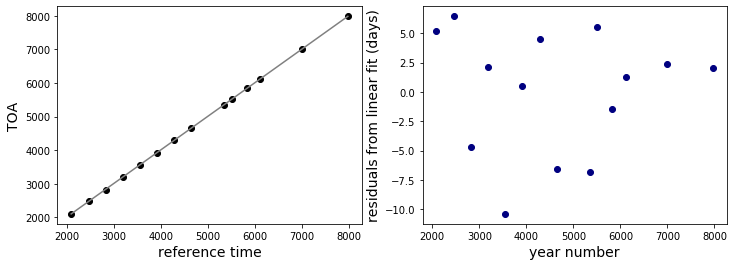

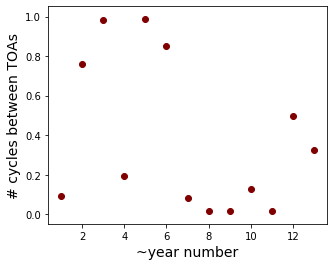

In [111]:
#from folds: not horrible phase shift, some shape deterioration
#21.96 days
toas,p = yearloop(30,0,start='current',mult=1,pbins=16,det=True,plot=False,findpd='best',lin=True)
cycle(toas,p)

18


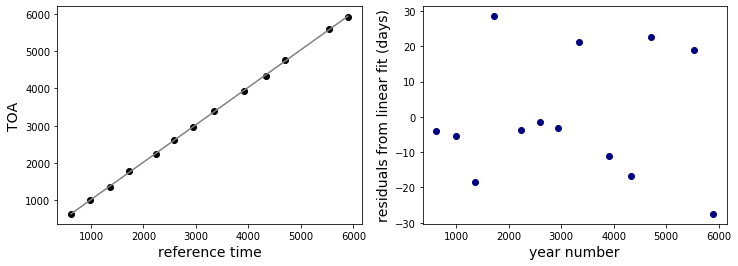

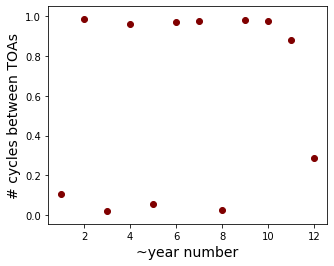

In [112]:
#should be another really good example; 59.71 days
toas,p = yearloop(45,0,start='current',mult=1,pbins=16,det=True,plot=False,findpd='est',lin=True)
cycle(toas,p)

18


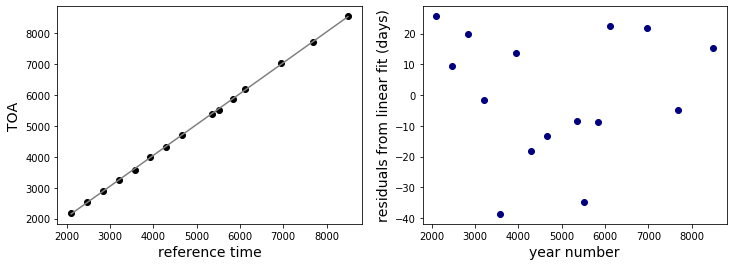

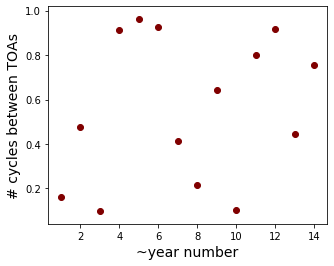

In [117]:
#'aperiodic' example
toas,p = yearloop(139,0,start='current',mult=1,pbins=16,det=True,plot=False,findpd='est',lin=True)
cycle(toas,p)